### Llama a Mental Model

In [7]:
#Packages to install 

#pip install torch transformers peft huggingface_hub
#pip install sentencepiece 
#pip install torch
#pip install tensorflow
#pip install flax
#pip install transformers peft torch
#pip install dask_labextension
#pip install tf-keras
#pip install seaborn
#pip install  scikit-learn

#- https://github.com/google/sentencepiece#installation
import torch

print(torch.cuda.is_available())  # Should return True

False


In [8]:
!sudo apt-get install git-lfs
# https://github.com/git-lfs/git-lfs/blob/main/INSTALLING.md

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package git-lfs


### Load Medium small MentalBart model - Part of the MentalLLaMa project

##### https://huggingface.co/Tianlin668/MentalBART

You can load the model directly, but using the pipline is probably easier, but I haven't made it work yet. I'm too tired
#### Use a pipeline as a high-level helper

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Tianlin668/MentalBART") 
model = AutoModelForSeq2SeqLM.from_pretrained("Tianlin668/MentalBART")



#### Load the model directly -  This works for now

In [9]:
from transformers import pipeline

pipe = pipeline("text-generation", model="Tianlin668/MentalBART")

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Tianlin668/MentalBART")
model = AutoModelForSeq2SeqLM.from_pretrained("Tianlin668/MentalBART")

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


In [4]:
# Example prompt
prompt = """I‘m supposed to increase my dosage today. I‘m on 2,5mg and I had a few sideffects for about a week." Question: what diagnosis could this person have?"""
inputs = tokenizer(prompt, return_tensors="pt")

# Generate
generate_ids = model.generate(inputs.input_ids, max_length=2048)
tokenizer.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

'bipolar disorder. Reasoning: The post mentions being on medication for bipolar disorder and experiencing side effects. The individual expresses concern about increasing their dosage and the possibility of the side effects returning or worsening. This suggests that the person may be dealing with bipolar disorder, as the medication is commonly prescribed for this condition.'

## Cassandra - Analysis 

Here we check out the working directory to access our files and chart the file path to verify the file is indeed in the location. Else analysis won't work. Need the files!

In [47]:
# Check for the working directory and file identification
# debugging if file exists
import os

# Check current directory
print("Current working directory:", os.getcwd())

# List all files in the current directory
print("Files in directory:", os.listdir())

# Check if the file exists at the specified path
file_path = "/work/Cassandra_Emily/MentalLLaMA-main/ProjectDataUse"
if os.path.exists(file_path):
    print("File found!")
else:
    print("File not found. Please verify the path.")

Current working directory: /work/Cassandra_Emily/MentalLLaMA-main
Files in directory: ['MentaLLaMA-33B-lora', 'src', 'Processed_Data', 'Our_folder', 'examples', 'README.md', 'ProjectDataUse', 'Cassandra_fuckAround.ipynb', 'LICENSE', 'saved_model', 'Emily_fuckAround-Copy1.ipynb', 'train_data', 'test_data', 'human_evaluation', 'BARTScore', 'FastChat', 'Reddit_data_withoutprompts', 'vicuna-33B', '.ipynb_checkpoints']
File found!


Here we process the data scraped from reddit into processed data. 
We feed the pretrained MentalBART model with the subreddit data and ran the model through each csv file.
Truncation of the data was necessary to ensure the model could handle the load, however the cost was lost data and potentially impacting the accuracy score in the analysis.

In [ ]:
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Tianlin668/MentalBART")
model = AutoModelForSeq2SeqLM.from_pretrained("Tianlin668/MentalBART")

# Load the CSV file
file_path = (
    "/work/Cassandra_Emily/MentalLLaMA-main/ProjectDataUse/schizophrenia_posts.csv"
)
data = pd.read_csv(file_path)

# Ensure the dataset has a 'Body' column
if "Body" not in data.columns:
    raise ValueError(
        f"The dataset must contain a column named 'Body'. Current columns: {data.columns}"
    )

# Remove rows where 'Body' is null or empty
data = data[data["Body"].notnull()]
data = data[data["Body"].str.strip() != ""]


# Define a function to build a prompt and generate a response
def generate_response(post):
    # Build a prompt using the post text
    prompt = f'Consider this post: "{post}" Question: What can you infer about this person\'s mental state?'

    # Tokenize and generate a response
    inputs = tokenizer(prompt, return_tensors="pt")
    generate_ids = model.generate(inputs.input_ids, max_length=2024)

    # Decode the response
    response = tokenizer.decode(
        generate_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return response


# Save results to a new CSV file


# Define a function to split the response into label and reasoning
def split_response(response):
    # Default values
    label = "Unknown"
    reasoning = "No reasoning provided"

    # Split the response into label and reasoning based on expected format
    if "Reasoning:" in response:
        parts = response.split("Reasoning:", maxsplit=1)
        label = parts[0].strip()  # Text before "Reasoning:"
        reasoning = parts[1].strip()  # Text after "Reasoning:"
    else:
        label = response  # If no "Reasoning:", assume the whole response is the label

    return label, reasoning


# Apply the functions to the 'Body' column
data["ModelResponse"] = data["Body"].apply(generate_response)
data[["Label", "Reasoning"]] = data["ModelResponse"].apply(
    lambda x: pd.Series(split_response(x))
)

# Save results to a new CSV file
output_file = "processed_schizophrenia_posts_with_responses.csv"
data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

Here is the modified code from above that truncated the data.
This code was modified, so to allow large textfiles, as the model was not able to handle the size of some of the reddit datasets

In [21]:
# long length

import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Tianlin668/MentalBART")
model = AutoModelForSeq2SeqLM.from_pretrained("Tianlin668/MentalBART")

# Load the CSV file
file_path = "/work/Cassandra_Emily/MentalLLaMA-main/ProjectDataUse/addiction_posts.csv"
data = pd.read_csv(file_path)

# Ensure the dataset has a 'Body' column
if "Body" not in data.columns:
    raise ValueError(
        f"The dataset must contain a column named 'Body'. Current columns: {data.columns}"
    )

# Remove rows where 'Body' is null or empty
data = data[data["Body"].notnull()]
data = data[data["Body"].str.strip() != ""]


# Define a function to build a prompt and generate a response
def generate_response(post):
    # Build a prompt using the post text
    prompt = f'Consider this post: "{post}" Question: What can you infer about this person\'s mental state?'

    # Tokenize and truncate the input to the model's max token limit
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)

    # Generate a response
    generate_ids = model.generate(inputs.input_ids, max_length=256)

    # Decode the response
    response = tokenizer.decode(
        generate_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return response


# Define a function to split the response into label and reasoning
def split_response(response):
    # Default values
    label = "Unknown"
    reasoning = "No reasoning provided"

    # Split the response into label and reasoning based on expected format
    if "Reasoning:" in response:
        parts = response.split("Reasoning:", maxsplit=1)
        label = parts[0].strip()  # Text before "Reasoning:"
        reasoning = parts[1].strip()  # Text after "Reasoning:"
    else:
        label = response  # If no "Reasoning:", assume the whole response is the label

    return label, reasoning


# Apply the functions to the 'Body' column
data["ModelResponse"] = data["Body"].apply(generate_response)
data[["Label", "Reasoning"]] = data["ModelResponse"].apply(
    lambda x: pd.Series(split_response(x))
)

# Save results to a new CSV file
output_file = "processed_addiction_posts_with_responses.csv"
data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

Processed data saved to processed_addiction_posts_with_responses.csv


Bar Plot to demonstrate the representation of data and get an idea of what the data looks like and how the model performed before deciding on models

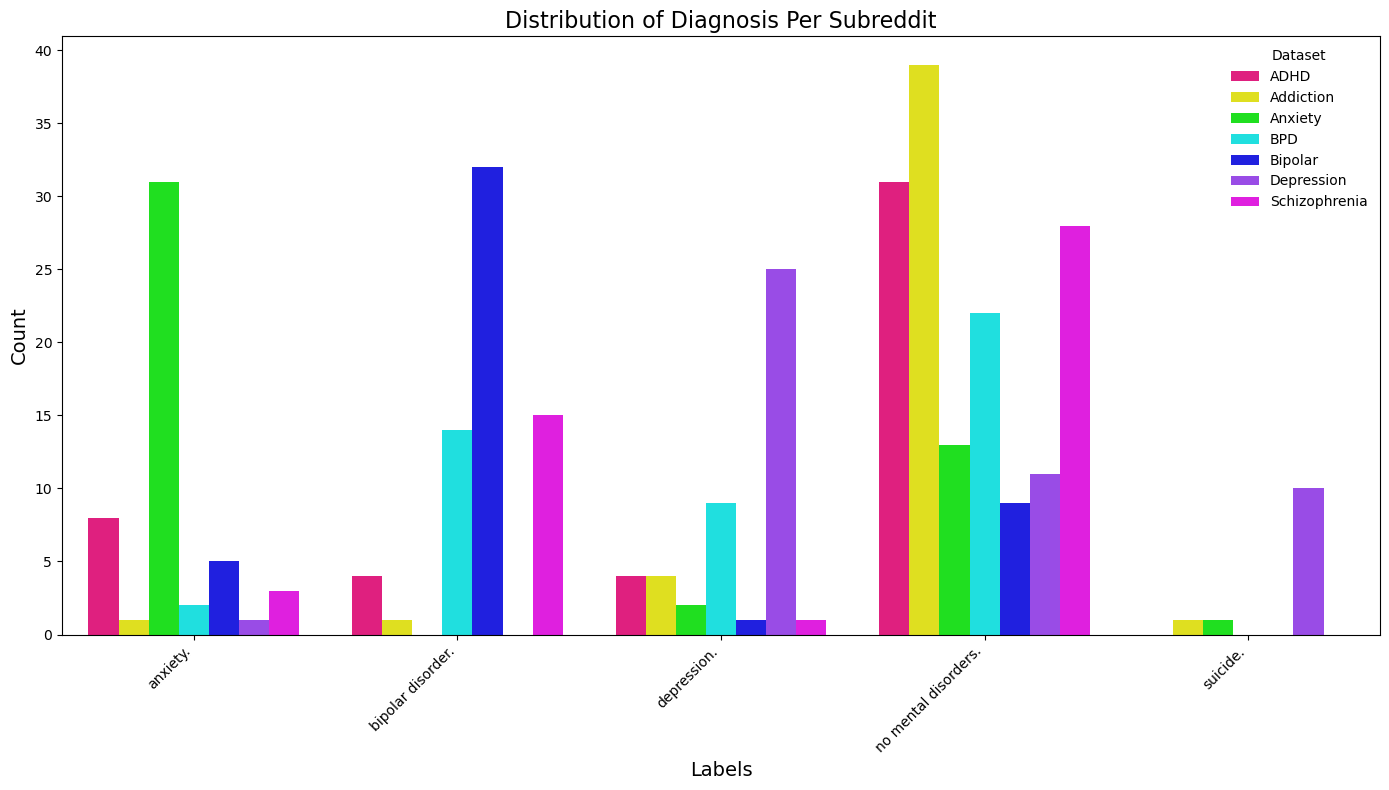

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# List of all file paths and their corresponding dataset names
file_paths = [
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_addiction_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_ADHD_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_Anxiety_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_bipolar_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_BPD_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_depression_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_schizophrenia_posts_with_responses.csv",
]

dataset_names = [
    "Addiction",
    "ADHD",
    "Anxiety",
    "Bipolar",
    "BPD",
    "Depression",
    "Schizophrenia",
]

# Initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# Read each CSV file, add a dataset name column, and append to the combined DataFrame
for file_path, dataset_name in zip(file_paths, dataset_names):
    df = pd.read_csv(file_path)
    if "Label" in df.columns:
        df["Dataset"] = dataset_name  # Add a column to indicate the dataset source
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Adjust the combined dataset
# Remove rows where 'Label' is "yes."
combined_data = combined_data[combined_data["Label"] != "yes."]

# Replace "no." with "no mental disorders." in the 'Label' column
combined_data["Label"] = combined_data["Label"].replace("no.", "no mental disorders.")

# Ensure the 'Label' and 'Dataset' columns exist
if "Label" not in combined_data.columns or "Dataset" not in combined_data.columns:
    raise ValueError(
        "One or more datasets do not contain the required 'Label' or 'Dataset' columns."
    )

# Count the occurrences of each label per dataset
label_counts_per_dataset = (
    combined_data.groupby(["Dataset", "Label"]).size().reset_index(name="Count")
)

# Create a custom palette with pink, yellow, green, blue, purple, and teal
custom_palette = [
    "#FF007F",
    "#FFFF00",
    "#00FF00",
    "#00FFFF",
    "#0000FF",
    "#9933FF",
    "#FF00FF",
]

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=label_counts_per_dataset,
    x="Label",
    y="Count",
    hue="Dataset",
    palette=custom_palette[: len(label_counts_per_dataset["Dataset"].unique())],
)
plt.title("Distribution of Diagnosis Per Subreddit", fontsize=16, color="black")
plt.xlabel("Labels", fontsize=14, color="black")
plt.ylabel("Count", fontsize=14, color="black")
plt.xticks(rotation=45, ha="right", color="black")
plt.yticks(color="black")
plt.legend(title="Dataset", loc="upper right", frameon=False)
plt.tight_layout()

# Show the plot
plt.show()

Pie Chart to show the data

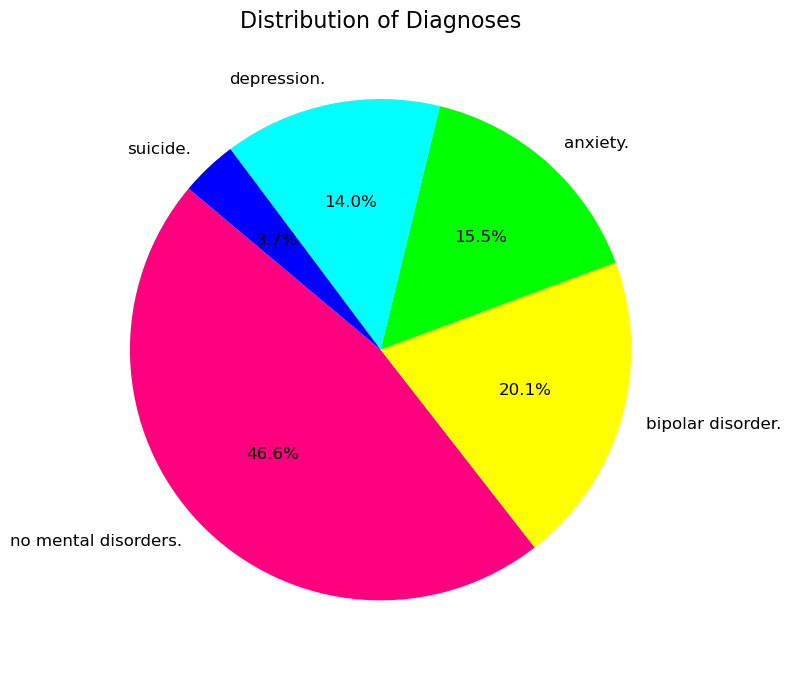

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Adjust labels
# Move "no." to "no mental disorders." and remove rows where Label is "yes."
combined_data["Label"] = combined_data["Label"].replace("no.", "no mental disorders.")
combined_data = combined_data[combined_data["Label"] != "yes."]

# Count occurrences of each label
label_counts = combined_data["Label"].value_counts()

# Custom palette for the pie chart
custom_palette = [
    "#FF007F",
    "#FFFF00",
    "#00FF00",
    "#00FFFF",
    "#0000FF",
    "#9933FF",
    "#FF00FF",
]

# Plot the pie chart with the custom palette
plt.figure(figsize=(8, 8))
plt.pie(
    label_counts.values,  # Values for the pie chart
    labels=label_counts.index,  # Labels for the sections
    autopct="%1.1f%%",  # Display percentages
    startangle=140,  # Start angle for the pie chart
    colors=custom_palette[: len(label_counts)],  # Apply custom palette
    textprops={"fontsize": 12},  # Text properties
)
plt.title("Distribution of Diagnoses", fontsize=16)
plt.tight_layout()
plt.show()

Let's look at all the files and merge them into one data frame.
How about an analysis to explain the distribution of data and percentages across the data set


In [13]:
import pandas as pd


# Recalculate the counts per dataset and label after adjustments
label_counts_per_dataset = (
    combined_data.groupby(["Dataset", "Label"]).size().reset_index(name="Count")
)

# Total count per dataset
total_counts_per_dataset = (
    combined_data.groupby("Dataset").size().reset_index(name="TotalCount")
)

# Merge the two dataframes for complete information
distribution_data = pd.merge(
    label_counts_per_dataset, total_counts_per_dataset, on="Dataset"
)

# Add a percentage column for label distribution
distribution_data["Percentage"] = (
    distribution_data["Count"] / distribution_data["TotalCount"]
) * 100

# Display the adjusted result
print(distribution_data)

          Dataset                 Label  Count  TotalCount  Percentage
0            ADHD              anxiety.      8          47   17.021277
1            ADHD     bipolar disorder.      4          47    8.510638
2            ADHD           depression.      4          47    8.510638
3            ADHD  no mental disorders.     31          47   65.957447
4       Addiction              anxiety.      1          46    2.173913
5       Addiction     bipolar disorder.      1          46    2.173913
6       Addiction           depression.      4          46    8.695652
7       Addiction  no mental disorders.     39          46   84.782609
8       Addiction              suicide.      1          46    2.173913
9         Anxiety              anxiety.     31          47   65.957447
10        Anxiety           depression.      2          47    4.255319
11        Anxiety  no mental disorders.     13          47   27.659574
12        Anxiety              suicide.      1          47    2.127660
13    

Description of the code below 

In acceptable matches I put in the categories by the dataset files *reddit* and then I paired it with what would be considered a match, what the model would deem as correct.
Checks the accuracy of the model

Accuracy = (The number of correct predictions/total number of predictions) x 100 
the 100 is to express the result as a percentage
Lists the datasets and labels


In [14]:
# Define custom acceptable matches data set with mental health disorders
acceptable_matches = {
    "Addiction": ["addiction.", "no.", "no mental disorders."],
    "ADHD": ["adhd."],
    "Anxiety": ["anxiety."],
    "Bipolar": ["bipolar disorder."],
    "BPD": ["bpd."],
    "Depression": ["depression."],
    "Schizophrenia": ["schizophrenia."],
}


# Create a custom column to check if predictions are correct
def is_correct_prediction(row):
    true_label = row["Label"]
    predicted_label = row["Dataset"]
    if true_label in acceptable_matches.get(predicted_label, []):
        return True
    return False


combined_data["CorrectPrediction"] = combined_data.apply(is_correct_prediction, axis=1)

# Calculate accuracy based on custom logic
accuracy = combined_data["CorrectPrediction"].mean() * 100
print(f"Custom Accuracy: {accuracy:.2f}%")

# Display mismatches for debugging
mismatches = combined_data[~combined_data["CorrectPrediction"]]
print("\nMismatched Predictions:\n", mismatches[["Dataset", "Label"]].head(20))

Custom Accuracy: 38.72%

Mismatched Predictions:
       Dataset                 Label
0   Addiction              suicide.
1   Addiction           depression.
10  Addiction           depression.
12  Addiction           depression.
20  Addiction              anxiety.
21  Addiction           depression.
27  Addiction     bipolar disorder.
47       ADHD  no mental disorders.
48       ADHD              anxiety.
49       ADHD  no mental disorders.
50       ADHD  no mental disorders.
51       ADHD           depression.
52       ADHD  no mental disorders.
53       ADHD  no mental disorders.
54       ADHD  no mental disorders.
55       ADHD  no mental disorders.
56       ADHD  no mental disorders.
57       ADHD  no mental disorders.
58       ADHD           depression.
59       ADHD  no mental disorders.


Confusion Matrix and Accuracy Assessment 

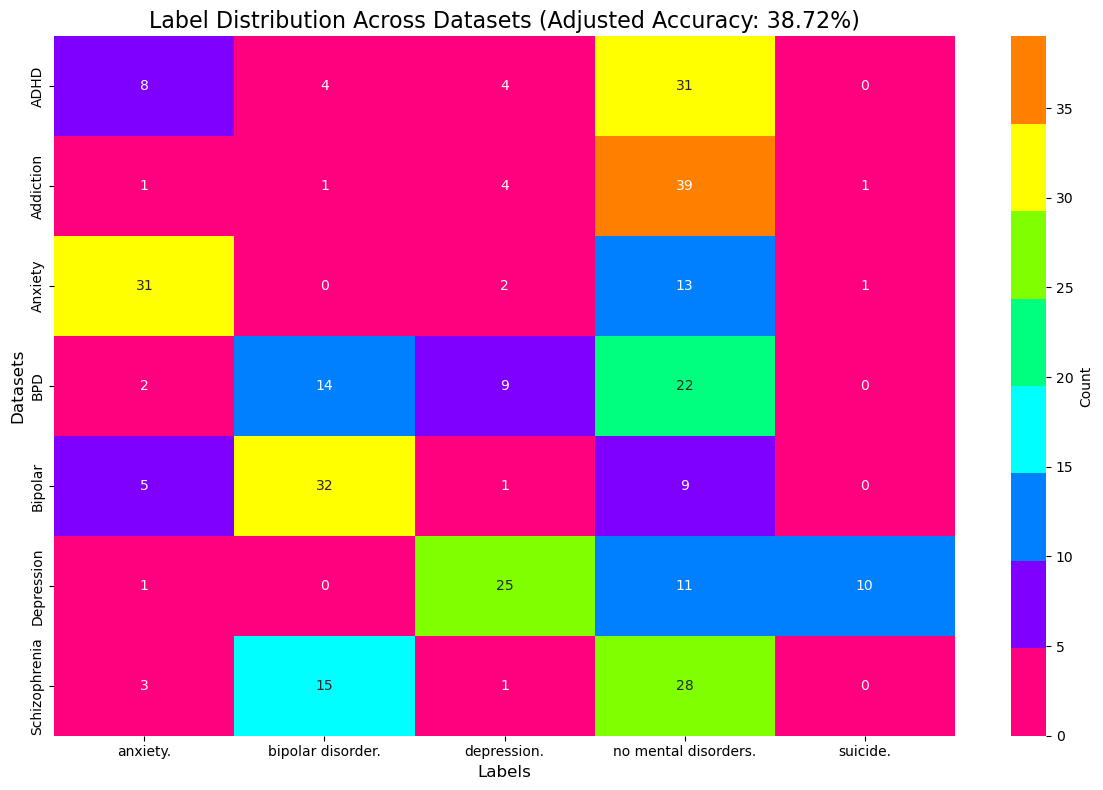

In [15]:
# Define custom acceptable matches for accuracy
acceptable_matches = {
    "Addiction": ["addiction.", "no mental disorders."],
    "ADHD": ["adhd."],
    "Anxiety": ["anxiety."],
    "Bipolar": ["bipolar disorder."],
    "BPD": ["bpd."],
    "Depression": ["depression."],
    "Schizophrenia": ["schizophrenia."],
}


# Function to check if a prediction is correct
def is_correct_prediction(row):
    true_label = row["Label"]
    predicted_label = row["Dataset"]
    return true_label in acceptable_matches.get(predicted_label, [])


# Create CorrectPrediction column
combined_data["CorrectPrediction"] = combined_data.apply(is_correct_prediction, axis=1)

# Calculate custom accuracy
adjusted_accuracy = combined_data["CorrectPrediction"].mean() * 100

# Use all unique labels and datasets
all_labels = sorted(combined_data["Label"].unique())
all_datasets = sorted(combined_data["Dataset"].unique())

# Reindex the heatmap data
label_counts = combined_data.groupby(["Dataset", "Label"]).size().unstack(fill_value=0)
label_counts = label_counts.reindex(
    index=all_datasets, columns=all_labels, fill_value=0
)

# Define harmonious custom rainbow palette
harmonious_palette = [
    "#FF007F",
    "#7F00FF",
    "#007FFF",
    "#00FFFF",
    "#00FF7F",
    "#7FFF00",
    "#FFFF00",
    "#FF7F00",
]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    label_counts,
    annot=True,  # Annotate with data values
    fmt="d",
    cmap=sns.color_palette(
        harmonious_palette, as_cmap=True
    ),  # Use custom harmonious palette
    cbar_kws={"label": "Count"},
)
plt.title(
    f"Label Distribution Across Datasets (Adjusted Accuracy: {adjusted_accuracy:.2f}%)",
    fontsize=16,
)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Datasets", fontsize=12)
plt.tight_layout()
plt.show()

more nos in no mental disorders and remove yes
Let's look at 
Accuracy: (TP+TN)/(TP+FP+FN+TN)
Precision: TP/(TP+FP)
Recall (Sensitivity):TP/(TP+FN)
Specificity: TN/(TN+FP)
F1-Score: 2 x (precision x recall)/(precision + recall)
PURPOSE
Identifying how well the model performs 

* True Positives (TP): Correctly predicted positive cases.
* False Positives (FP): Incorrectly predicted positive cases.
* False Negatives (FN): Missed positive cases.
* True Negatives (TN): Correctly predicted negative cases.

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Adjust the data
# Move 'no.' into 'no mental disorders.' and remove 'yes.'
combined_data["Label"] = combined_data["Label"].replace("no.", "no mental disorders.")
combined_data = combined_data[combined_data["Label"] != "yes."]

# Use all unique labels from the dataset
all_labels = sorted(combined_data["Label"].unique())
all_datasets = sorted(combined_data["Dataset"].unique())

# Map Dataset to expected Label
dataset_to_label_mapping = {
    "Addiction": "addiction.",
    "ADHD": "adhd.",
    "Anxiety": "anxiety.",
    "Bipolar": "bipolar disorder.",
    "BPD": "bpd.",
    "Depression": "depression.",
    "Schizophrenia": "schizophrenia.",
}

# Add PredictedLabel column based on Dataset mapping
combined_data["PredictedLabel"] = combined_data["Dataset"].map(dataset_to_label_mapping)

# Ensure proper reindexing for the heatmap data
label_counts = combined_data.groupby(["Dataset", "Label"]).size().unstack(fill_value=0)
label_counts = label_counts.reindex(
    index=all_datasets, columns=all_labels, fill_value=0
)

# Create a confusion matrix
labels = combined_data["Label"].unique()  # Unique class labels
predicted_labels = combined_data["PredictedLabel"]

# Generate confusion matrix
conf_matrix = confusion_matrix(
    combined_data["Label"], predicted_labels, labels=all_labels
)

# Initialize dictionaries to store results
TP, FP, FN, TN = {}, {}, {}, {}

# Calculate TP, FP, FN, TN for each class
for i, label in enumerate(all_labels):
    TP[label] = conf_matrix[i, i]
    FP[label] = conf_matrix[:, i].sum() - TP[label]
    FN[label] = conf_matrix[i, :].sum() - TP[label]
    TN[label] = conf_matrix.sum() - (TP[label] + FP[label] + FN[label])

# Display results
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

# Convert results to a DataFrame for visualization
metrics = pd.DataFrame({"TP": TP, "FP": FP, "FN": FN, "TN": TN})
print("\nMetrics for Each Class:\n", metrics)

True Positives (TP): {'anxiety.': np.int64(31), 'bipolar disorder.': np.int64(32), 'depression.': np.int64(25), 'no mental disorders.': np.int64(0), 'suicide.': np.int64(0)}
False Positives (FP): {'anxiety.': np.int64(16), 'bipolar disorder.': np.int64(15), 'depression.': np.int64(22), 'no mental disorders.': np.int64(0), 'suicide.': np.int64(0)}
False Negatives (FN): {'anxiety.': np.int64(6), 'bipolar disorder.': np.int64(0), 'depression.': np.int64(3), 'no mental disorders.': np.int64(33), 'suicide.': np.int64(11)}
True Negatives (TN): {'anxiety.': np.int64(88), 'bipolar disorder.': np.int64(94), 'depression.': np.int64(91), 'no mental disorders.': np.int64(108), 'suicide.': np.int64(130)}

Metrics for Each Class:
                       TP  FP  FN   TN
anxiety.              31  16   6   88
bipolar disorder.     32  15   0   94
depression.           25  22   3   91
no mental disorders.   0   0  33  108
suicide.               0   0  11  130


And let's visualise it!

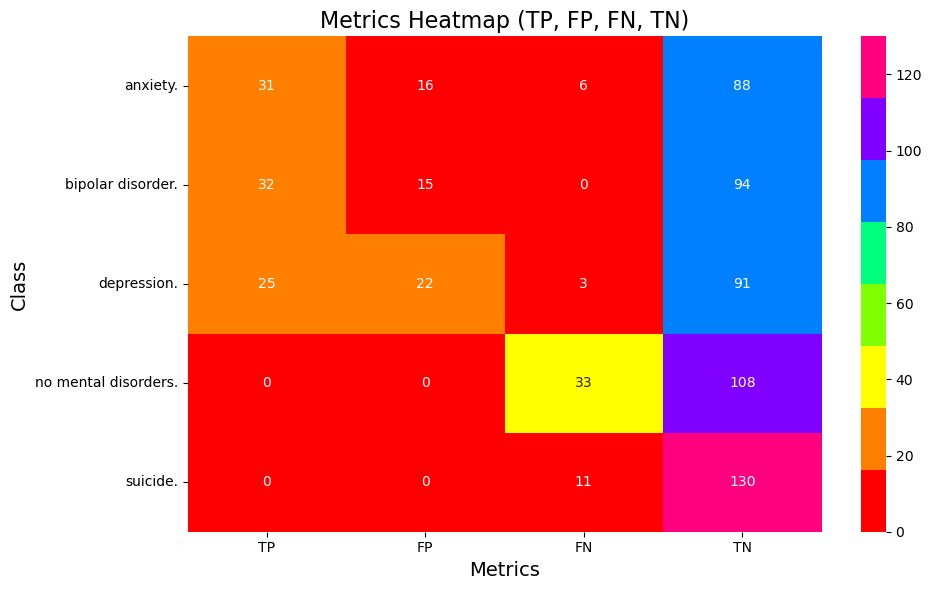

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a more harmonious custom rainbow palette
harmonious_palette = sns.color_palette(
    [
        "#FF0000",
        "#FF7F00",
        "#FFFF00",
        "#7FFF00",
        "#00FF7F",
        "#007FFF",
        "#7F00FF",
        "#FF007F",
    ],
    as_cmap=True,
)

# Plot the heatmap with the harmonious palette
plt.figure(figsize=(10, 6))
sns.heatmap(
    metrics,
    annot=True,
    cmap=sns.color_palette(harmonious_palette, as_cmap=True),
    fmt="d",
    cbar=True,
)
plt.title("Metrics Heatmap (TP, FP, FN, TN)", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.tight_layout()
plt.show()

Let's make a classification report to evaluate the performance of our model
Let's look at 
Accuracy: (TP+TN)/(TP+FP+FN+TN)
Precision: TP/(TP+FP)
Recall (Sensitivity):TP/(TP+FN)
Specificity: TN/(TN+FP)
F1-Score: 2 x (precision x recall)/(precision + recall)

In [18]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Ensure PredictedLabel mapping is consistent
dataset_to_label_mapping = {
    "Addiction": "addiction.",
    "ADHD": "adhd.",
    "Anxiety": "anxiety.",
    "Bipolar": "bipolar disorder.",
    "BPD": "bpd.",
    "Depression": "depression.",
    "Schizophrenia": "schizophrenia.",
}

combined_data["PredictedLabel"] = combined_data["Dataset"].map(dataset_to_label_mapping)

# Check unique labels
true_labels = combined_data["Label"].unique()
predicted_labels = combined_data["PredictedLabel"].unique()

print("Unique True Labels:", true_labels)
print("Unique Predicted Labels:", predicted_labels)

# Align labels for consistency
all_labels = sorted(set(true_labels).union(set(predicted_labels)))
print("Aligned Labels:", all_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(
    combined_data["Label"], combined_data["PredictedLabel"], labels=all_labels
)

# Generate classification report
report = classification_report(
    combined_data["Label"],
    combined_data["PredictedLabel"],
    labels=all_labels,
    target_names=all_labels,
    zero_division=0,  # Handle undefined metrics gracefully
)
print("\nClassification Report:\n", report)

# Optional: Display the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=all_labels, columns=all_labels)
print("\nConfusion Matrix:\n", conf_matrix_df)

Unique True Labels: ['suicide.' 'depression.' 'no mental disorders.' 'anxiety.'
 'bipolar disorder.']
Unique Predicted Labels: ['addiction.' 'adhd.' 'anxiety.' 'bipolar disorder.' 'bpd.' 'depression.'
 'schizophrenia.']
Aligned Labels: ['addiction.', 'adhd.', 'anxiety.', 'bipolar disorder.', 'bpd.', 'depression.', 'no mental disorders.', 'schizophrenia.', 'suicide.']

Classification Report:
                       precision    recall  f1-score   support

          addiction.       0.00      0.00      0.00         0
               adhd.       0.00      0.00      0.00         0
            anxiety.       0.66      0.61      0.63        51
   bipolar disorder.       0.68      0.48      0.57        66
                bpd.       0.00      0.00      0.00         0
         depression.       0.53      0.54      0.54        46
no mental disorders.       0.00      0.00      0.00       153
      schizophrenia.       0.00      0.00      0.00         0
            suicide.       0.00      0.00     

Lets Model with just Anxiety, Bipolar, and Depression because the model performed better in identifying these. Let's see how the model performs here. Does it change?

In [10]:
# how is the accuracy for just anxiety, bipolar and depression?

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Combine all datasets into a single DataFrame
file_paths = [
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_Anxiety_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_bipolar_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_depression_posts_with_responses.csv",
]
dataset_names = ["Anxiety", "Bipolar", "Depression"]

combined_data = pd.DataFrame()
for file_path, dataset_name in zip(file_paths, dataset_names):
    df = pd.read_csv(file_path)
    if "Label" in df.columns:
        df["Dataset"] = dataset_name  # Add a column for dataset name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Use all unique labels from the dataset
all_labels = sorted(combined_data["Label"].unique())
all_datasets = sorted(combined_data["Dataset"].unique())

# Map Dataset to expected Label
dataset_to_label_mapping = {
    "Anxiety": "anxiety.",
    "Bipolar": "bipolar disorder.",
    "Depression": "depression.",
}

# Add PredictedLabel column based on Dataset mapping
combined_data["PredictedLabel"] = combined_data["Dataset"].map(dataset_to_label_mapping)

# Ensure proper reindexing for the heatmap data
label_counts = combined_data.groupby(["Dataset", "Label"]).size().unstack(fill_value=0)
label_counts = label_counts.reindex(
    index=all_datasets, columns=all_labels, fill_value=0
)

# Create a confusion matrix
labels = combined_data["Label"].unique()  # Unique class labels
predicted_labels = combined_data["PredictedLabel"]

# Generate confusion matrix
conf_matrix = confusion_matrix(
    combined_data["Label"], predicted_labels, labels=all_labels
)

# Initialize dictionaries to store results
TP, FP, FN, TN = {}, {}, {}, {}

# Calculate TP, FP, FN, TN for each class
for i, label in enumerate(all_labels):
    TP[label] = conf_matrix[i, i]
    FP[label] = conf_matrix[:, i].sum() - TP[label]
    FN[label] = conf_matrix[i, :].sum() - TP[label]
    TN[label] = conf_matrix.sum() - (TP[label] + FP[label] + FN[label])

# Display results
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

# Convert results to a DataFrame for visualization
metrics = pd.DataFrame({"TP": TP, "FP": FP, "FN": FN, "TN": TN})
print("\nMetrics for Each Class:\n", metrics)

True Positives (TP): {'anxiety.': np.int64(31), 'bipolar disorder.': np.int64(32), 'depression.': np.int64(25), 'no mental disorders.': np.int64(0), 'suicide.': np.int64(0)}
False Positives (FP): {'anxiety.': np.int64(16), 'bipolar disorder.': np.int64(15), 'depression.': np.int64(22), 'no mental disorders.': np.int64(0), 'suicide.': np.int64(0)}
False Negatives (FN): {'anxiety.': np.int64(6), 'bipolar disorder.': np.int64(0), 'depression.': np.int64(3), 'no mental disorders.': np.int64(33), 'suicide.': np.int64(11)}
True Negatives (TN): {'anxiety.': np.int64(88), 'bipolar disorder.': np.int64(94), 'depression.': np.int64(91), 'no mental disorders.': np.int64(108), 'suicide.': np.int64(130)}

Metrics for Each Class:
                       TP  FP  FN   TN
anxiety.              31  16   6   88
bipolar disorder.     32  15   0   94
depression.           25  22   3   91
no mental disorders.   0   0  33  108
suicide.               0   0  11  130


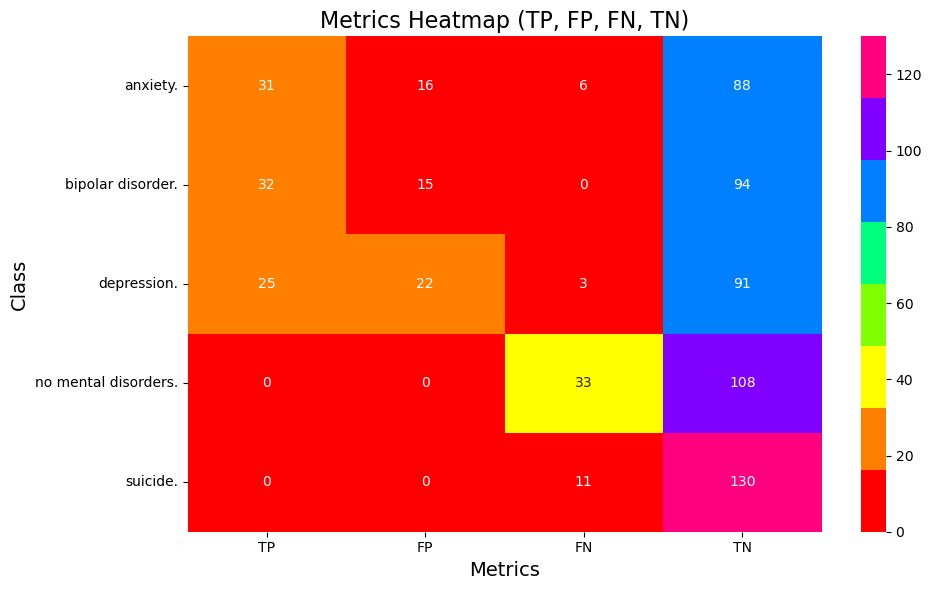

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a more harmonious custom rainbow palette
harmonious_palette = sns.color_palette(
    [
        "#FF0000",
        "#FF7F00",
        "#FFFF00",
        "#7FFF00",
        "#00FF7F",
        "#007FFF",
        "#7F00FF",
        "#FF007F",
    ],
    as_cmap=True,
)

# Plot the heatmap with the harmonious palette
plt.figure(figsize=(10, 6))
sns.heatmap(
    metrics,
    annot=True,
    cmap=sns.color_palette(harmonious_palette, as_cmap=True),
    fmt="d",
    cbar=True,
)
plt.title("Metrics Heatmap (TP, FP, FN, TN)", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.tight_layout()
plt.show()

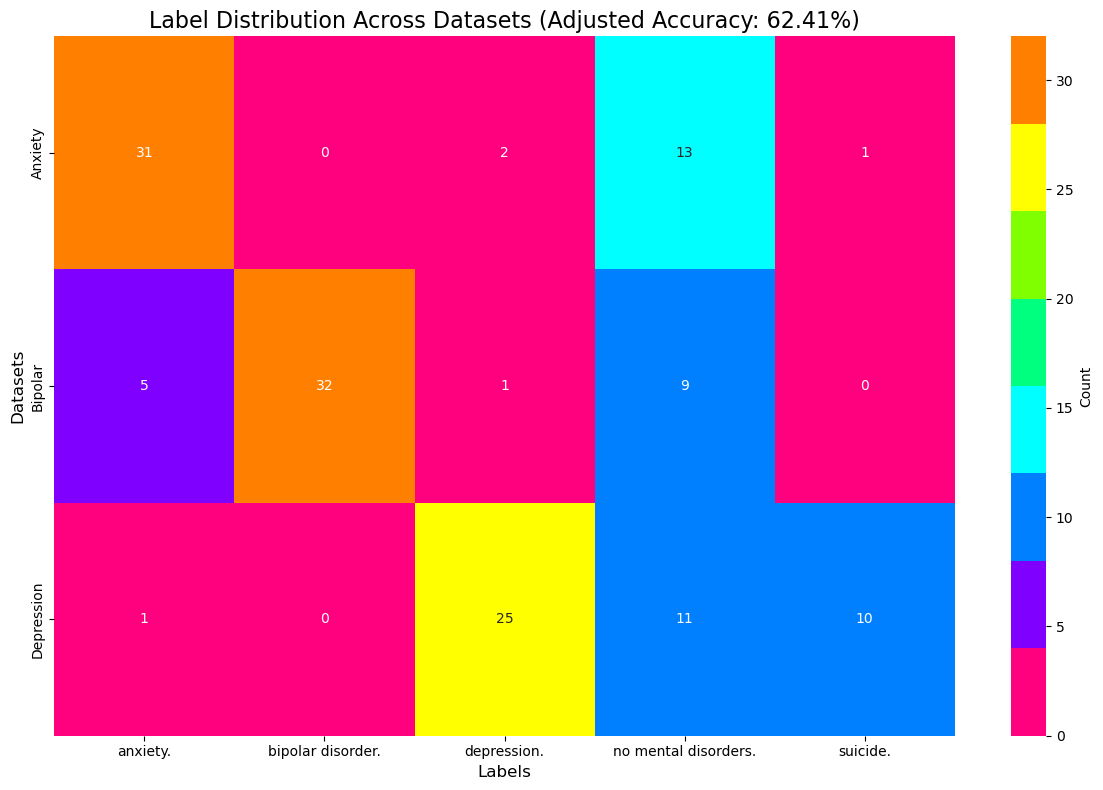

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

# Combine all datasets into a single DataFrame
file_paths = [
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_Anxiety_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_bipolar_posts_with_responses.csv",
    "/work/Cassandra_Emily/MentalLLaMA-main/Processed_Data/processed_depression_posts_with_responses.csv",
]
dataset_names = [
    "Anxiety",
    "Bipolar",
    "Depression",
]

combined_data = pd.DataFrame()
for file_path, dataset_name in zip(file_paths, dataset_names):
    df = pd.read_csv(file_path)
    if "Label" in df.columns:
        df["Dataset"] = dataset_name  # Add a column for dataset name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Use all unique labels from the dataset
all_labels = sorted(combined_data["Label"].unique())
all_datasets = sorted(combined_data["Dataset"].unique())

# Define custom acceptable matches for accuracy
acceptable_matches = {
    "Anxiety": ["anxiety."],
    "Bipolar": ["bipolar disorder."],
    "Depression": ["depression."],
}


# why isn't the model including adhd, bpd, and schizophrenia?
# Create a custom column to check if predictions are correct
def is_correct_prediction(row):
    true_label = row["Label"]
    predicted_label = row["Dataset"]
    return true_label in acceptable_matches.get(predicted_label, [])


combined_data["CorrectPrediction"] = combined_data.apply(is_correct_prediction, axis=1)

# Calculate custom accuracy
adjusted_accuracy = combined_data["CorrectPrediction"].mean() * 100

# Reindex the heatmap data to ensure all labels and datasets are included
label_counts = combined_data.groupby(["Dataset", "Label"]).size().unstack(fill_value=0)
label_counts = label_counts.reindex(
    index=all_datasets, columns=all_labels, fill_value=0
)

# Define the harmonious custom rainbow palette
harmonious_palette = [
    "#FF007F",
    "#7F00FF",
    "#007FFF",
    "#00FFFF",
    "#00FF7F",
    "#7FFF00",
    "#FFFF00",
    "#FF7F00",
]

# Plot the heatmap with the harmonious rainbow palette
plt.figure(figsize=(12, 8))
sns.heatmap(
    label_counts,
    annot=True,  # Annotate with data values
    fmt="d",
    cmap=sns.color_palette(
        harmonious_palette, as_cmap=True
    ),  # Use the custom harmonious palette
    cbar_kws={"label": "Count"},
)
plt.title(
    f"Label Distribution Across Datasets (Adjusted Accuracy: {adjusted_accuracy:.2f}%)",
    fontsize=16,
)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Datasets", fontsize=12)
plt.tight_layout()
plt.show()

Probability Based Confusion Matrix



This was an experiment to see how a bayesian confusion matrix looks and evaluating which is better for use

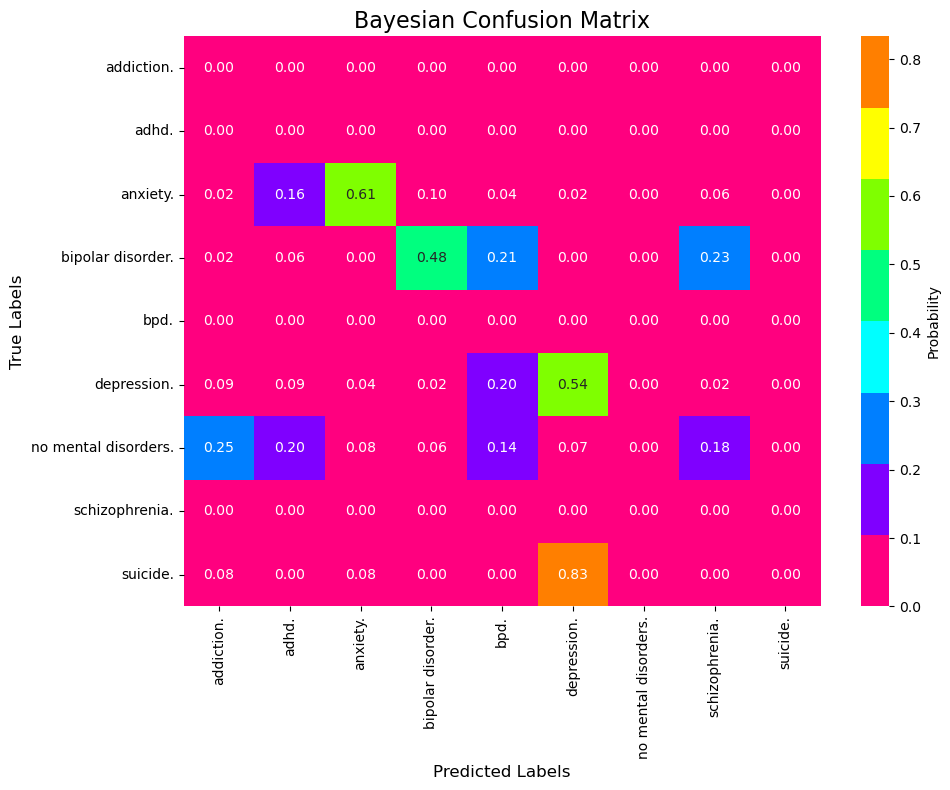

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Generate confusion matrix
conf_matrix = confusion_matrix(
    combined_data["Label"], combined_data["PredictedLabel"], labels=all_labels
)

# Handle rows with zero counts
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_prob = np.divide(
    conf_matrix, row_sums, where=row_sums != 0
)  # Avoid division by zero
conf_matrix_prob = np.nan_to_num(conf_matrix_prob, nan=0.0)  # Replace NaNs with 0

# Create DataFrame for easier visualization
conf_matrix_df = pd.DataFrame(conf_matrix_prob, index=all_labels, columns=all_labels)

# Define the harmonious custom rainbow palette
harmonious_palette = [
    "#FF007F",
    "#7F00FF",
    "#007FFF",
    "#00FFFF",
    "#00FF7F",
    "#7FFF00",
    "#FFFF00",
    "#FF7F00",
]

# Plot the Bayesian confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_df,
    annot=True,
    cmap=sns.color_palette(
        harmonious_palette, as_cmap=True
    ),  # Use the harmonious palette
    fmt=".2f",
    cbar_kws={"label": "Probability"},
)
plt.title("Bayesian Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.tight_layout()
plt.show()